In [1]:
from multiprocessing import Pool, cpu_count

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from obp.ope import RegressionModel

from abstraction import AbstractionLearner, ActionEmbeddingModel
from dataset import ExtremeBanditDataset
from policy import gen_eps_greedy
from estimator import InversePropensityScore as IPS
from estimator import MarginalizedIPS as MIPS
from estimator import DoublyRobust as DR
from estimator_tuning import SLOPE
from importance_weight import marginal_weight
from lower_bound import estimate_student_t_lower_bound
from util import (
    ActionEmbedOffPolicyEvaluation, 
    aggregate_simulation_results, 
    visualize_mean_squared_error,
    visualize_cdf_of_ralative_error
)


/usr/local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# setting

# 変数
val_sizes = [500, 2000, 3500, 5000]

# 定数
dataset_name = "EUR-Lex4K"
n_sim = 100
eps = 0.3
ope_estimators = [
    IPS(estimator_name="IPS"), 
    DR(estimator_name="DR"), 
    MIPS(estimator_name="MIPS (true)")
]
random_state = 12345
dim_context = 10

### Abstraction setting

hidden_size=5
n_cat_dim=5
n_cat_per_dim=5
learning_rate=0.001
num_epochs=10
batch_size=10
weight_decay=0.01
is_discrete=True

ope_estimators_tune = [
    SLOPE(
        estimator=MIPS(estimator_name="MIPS (true)-SLOPE"),
        hyper_param=np.arange(n_cat_dim),
        param_name="action_embed_dim",
        lower_bound_func=estimate_student_t_lower_bound,
        weight_func=marginal_weight,
        tuning_method="greedy_combination",
        min_combination=1
    )
]


done load raw data
done pre process
number of action: 3956


Training Abstraction Model: 100% 10/10 [01:05<00:00,  6.53s/it]


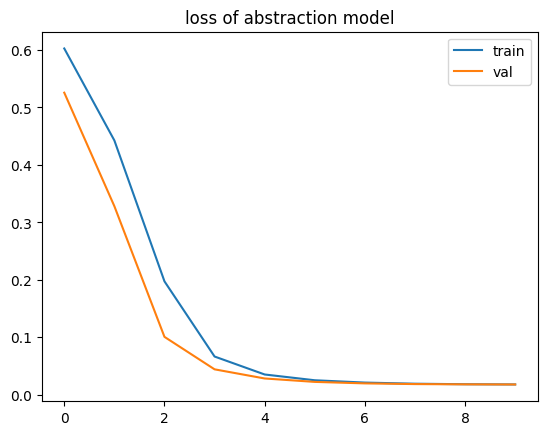

In [3]:
# experiment with "EUR-Lex4K" dataset contained in the Extreme Classification Repository.

dataset = ExtremeBanditDataset(dataset_name=dataset_name, random_state=random_state, n_components=dim_context)
print(f"number of action: {dataset.n_actions}")

action_dist = gen_eps_greedy(expected_reward=dataset.train_expected_rewards, eps=eps)
policy_value = dataset.calc_ground_truth_policy_value(expected_reward=dataset.train_expected_rewards, action_dist=action_dist)

## train a abstraction to obtain action embeddings
learner = AbstractionLearner(
    model=ActionEmbeddingModel(dim_context=dim_context, n_actions=dataset.n_actions, hidden_size=hidden_size, n_cat_dim=n_cat_dim),
    hidden_size=hidden_size,
    n_cat_dim=n_cat_dim,
    n_cat_per_dim=n_cat_per_dim,
    learning_rate=learning_rate,
    num_epochs=num_epochs,
    batch_size=batch_size,
    weight_decay=weight_decay,
    is_discrete=is_discrete
)

learner.fit(context=dataset.test_contexts, action=dataset.test_label)
unique_action_context = learner.obtain_action_embedding()

#health check
plt.title('loss of abstraction model')
plt.plot(learner.train_loss, label="train")
plt.plot(learner.val_loss, label="val")
plt.legend()
plt.show()

In [4]:
result_df_list = []
for val_size in val_sizes:
    result_list = []
    for _ in tqdm(range(n_sim), desc=f"val_size={val_size}..."):
        # generate synthetic data
        val_data = dataset.obtain_batch_bandit_feedback(n_rounds=val_size)
        val_data["action_context"] = unique_action_context[val_data["action"]]
        val_data["unique_action_context"] = unique_action_context
        
        q_hat = val_data["expected_reward"] + np.random.normal(size=(val_size, dataset.n_actions))

        # evaluation policy
        action_dist = gen_eps_greedy(expected_reward=val_data["expected_reward"], eps=eps)

        # off policy evaluation
        ope = ActionEmbedOffPolicyEvaluation(
            bandit_feedback=val_data,
            ope_estimators=ope_estimators,
            ope_estimators_tune=ope_estimators_tune
        )
        estimated_policy_values = ope.estimate_policy_values(action_dist=action_dist, estimated_rewards=q_hat)
        result_list.append(estimated_policy_values)
    
    # calculate MSE
    result_df = aggregate_simulation_results(
        simulation_result_list=result_list,
        policy_value=policy_value,
        x_value=val_size
    )
    result_df_list.append(result_df)
        
result_df = pd.concat(result_df_list).reset_index(level=0)

val_size=500...: 100% 100/100 [02:07<00:00,  1.28s/it]
val_size=2000...: 100% 100/100 [07:49<00:00,  4.69s/it]
val_size=3500...: 100% 100/100 [15:13<00:00,  9.14s/it]
val_size=5000...: 100% 100/100 [20:16<00:00, 12.17s/it]


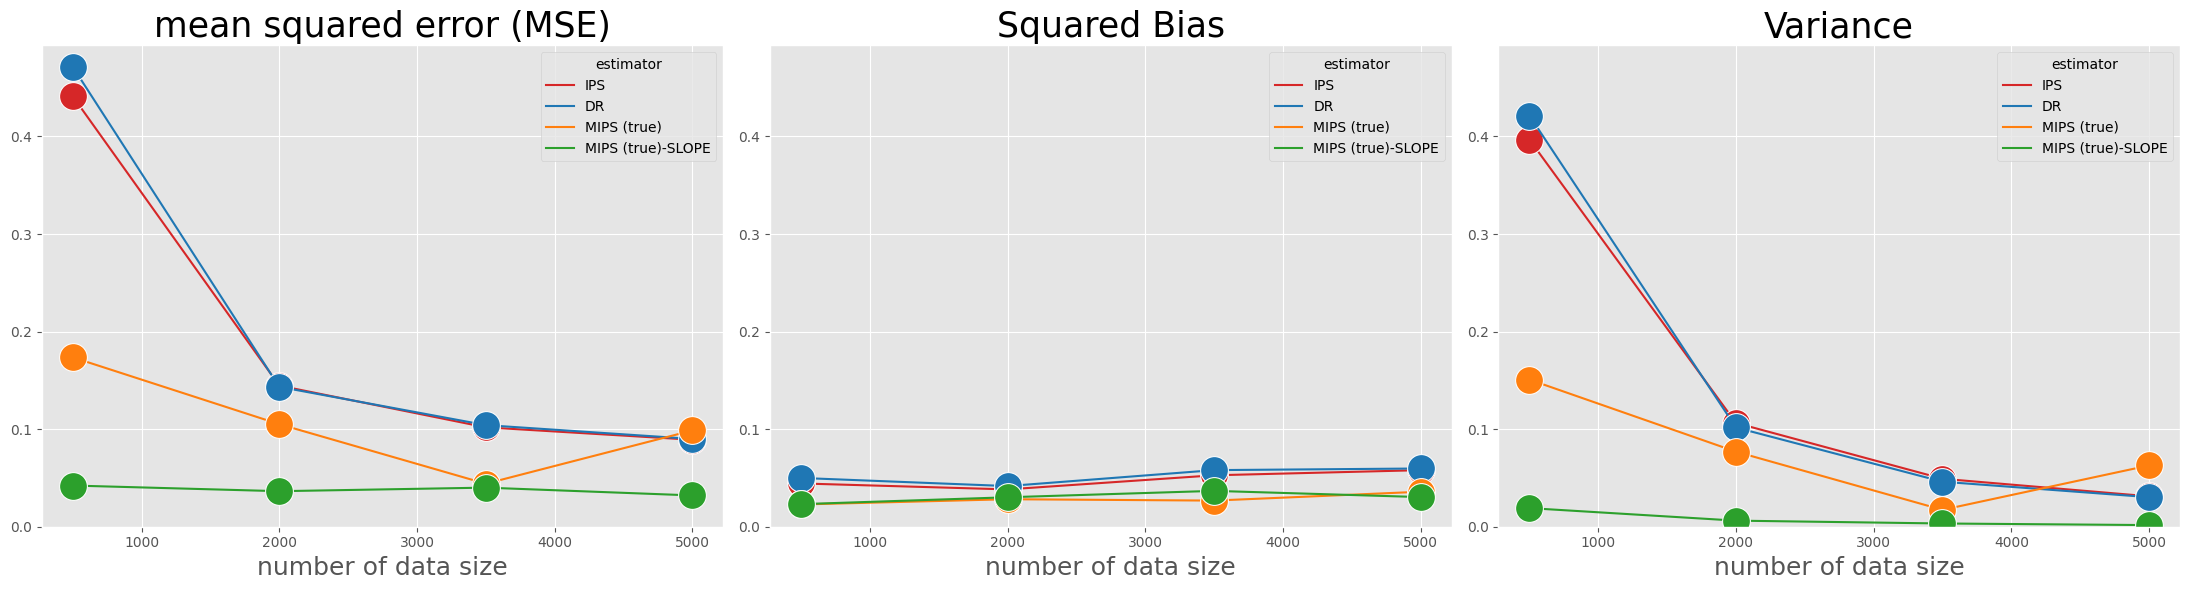

In [5]:
visualize_mean_squared_error(result_df=result_df, xlabel="number of data size")

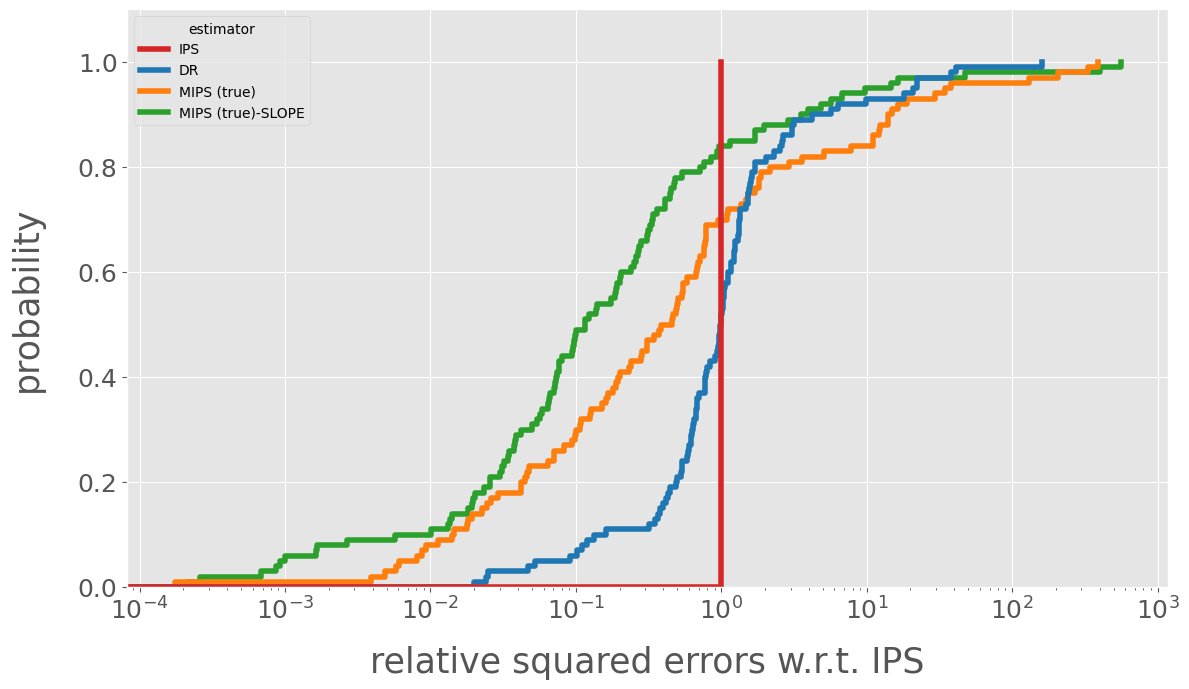

In [7]:
# CDF of Ralative Error
rel_result_df = result_df[result_df["x"] == 500].copy()
visualize_cdf_of_ralative_error(rel_result_df=rel_result_df)

In [8]:
# setting 2

# 変数
val_sizes = [1000]

# 定数
dataset_name = "RCV1-2K"
n_sim = 100
eps = 0.3
ope_estimators = [IPS(estimator_name="IPS"), DR(estimator_name="DR"), MIPS(estimator_name="MIPS (true)")]
random_state = 12345
dim_context = 10

### Abstraction setting

hidden_size=5
n_cat_dim=5
n_cat_per_dim=5
learning_rate=0.001
num_epochs=10
batch_size=10
weight_decay=0.01
is_discrete=True

ope_estimators_tune = [
    SLOPE(
        estimator=MIPS(estimator_name="MIPS (true)-SLOPE"),
        hyper_param=np.arange(n_cat_dim),
        param_name="action_embed_dim",
        lower_bound_func=estimate_student_t_lower_bound,
        weight_func=marginal_weight,
        tuning_method="greedy_combination",
        min_combination=1
    )
]


done load raw data
done pre process
number of action: 1832


Training Abstraction Model: 100% 10/10 [00:30<00:00,  3.06s/it]


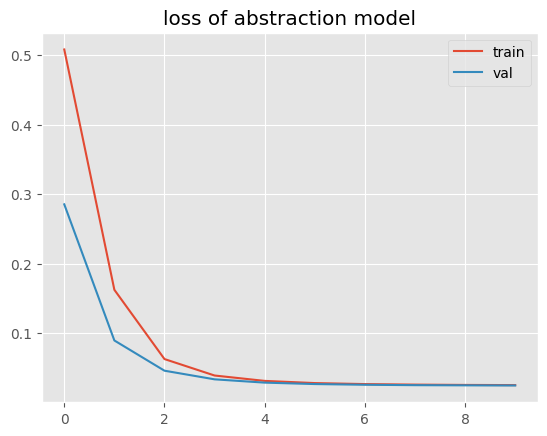

In [9]:
# experiment with "RCV1-2K" dataset contained in the Extreme Classification Repository.

dataset = ExtremeBanditDataset(dataset_name=dataset_name, random_state=random_state, n_components=dim_context)
print(f"number of action: {dataset.n_actions}")

action_dist = gen_eps_greedy(expected_reward=dataset.train_expected_rewards, eps=eps)
policy_value = dataset.calc_ground_truth_policy_value(expected_reward=dataset.train_expected_rewards, action_dist=action_dist)

## train a abstraction to obtain action embeddings
learner = AbstractionLearner(
    model=ActionEmbeddingModel(dim_context=dim_context, n_actions=dataset.n_actions, hidden_size=hidden_size, n_cat_dim=n_cat_dim),
    hidden_size=hidden_size,
    n_cat_dim=n_cat_dim,
    n_cat_per_dim=n_cat_per_dim,
    learning_rate=learning_rate,
    num_epochs=num_epochs,
    batch_size=batch_size,
    weight_decay=weight_decay,
    is_discrete=is_discrete
)

learner.fit(context=dataset.test_contexts, action=dataset.test_label)
unique_action_context = learner.obtain_action_embedding()

# health check
plt.title('loss of abstraction model')
plt.plot(learner.train_loss, label="train")
plt.plot(learner.val_loss, label="val")
plt.legend()
plt.show()

In [10]:
result_df_list = []
for val_size in val_sizes:
    result_list = []
    for _ in tqdm(range(n_sim), desc=f"val_size={val_size}..."):
        # generate synthetic data
        val_data = dataset.obtain_batch_bandit_feedback(n_rounds=val_size)
        val_data["action_context"] = unique_action_context[val_data["action"]]
        val_data["unique_action_context"] = unique_action_context
        
        q_hat = val_data["expected_reward"] + np.random.normal(size=(val_size, dataset.n_actions))

        # evaluation policy
        action_dist = gen_eps_greedy(expected_reward=val_data["expected_reward"], eps=eps)

        # off policy evaluation
        ope = ActionEmbedOffPolicyEvaluation(
            bandit_feedback=val_data,
            ope_estimators=ope_estimators,
            ope_estimators_tune=ope_estimators_tune
        )
        estimated_policy_values = ope.estimate_policy_values(action_dist=action_dist, estimated_rewards=q_hat)
        result_list.append(estimated_policy_values)
    
    # calculate MSE
    result_df = aggregate_simulation_results(
        simulation_result_list=result_list,
        policy_value=policy_value,
        x_value=val_size
    )
    result_df_list.append(result_df)
        
result_df = pd.concat(result_df_list).reset_index(level=0)

val_size=1000...: 100% 100/100 [01:45<00:00,  1.05s/it]


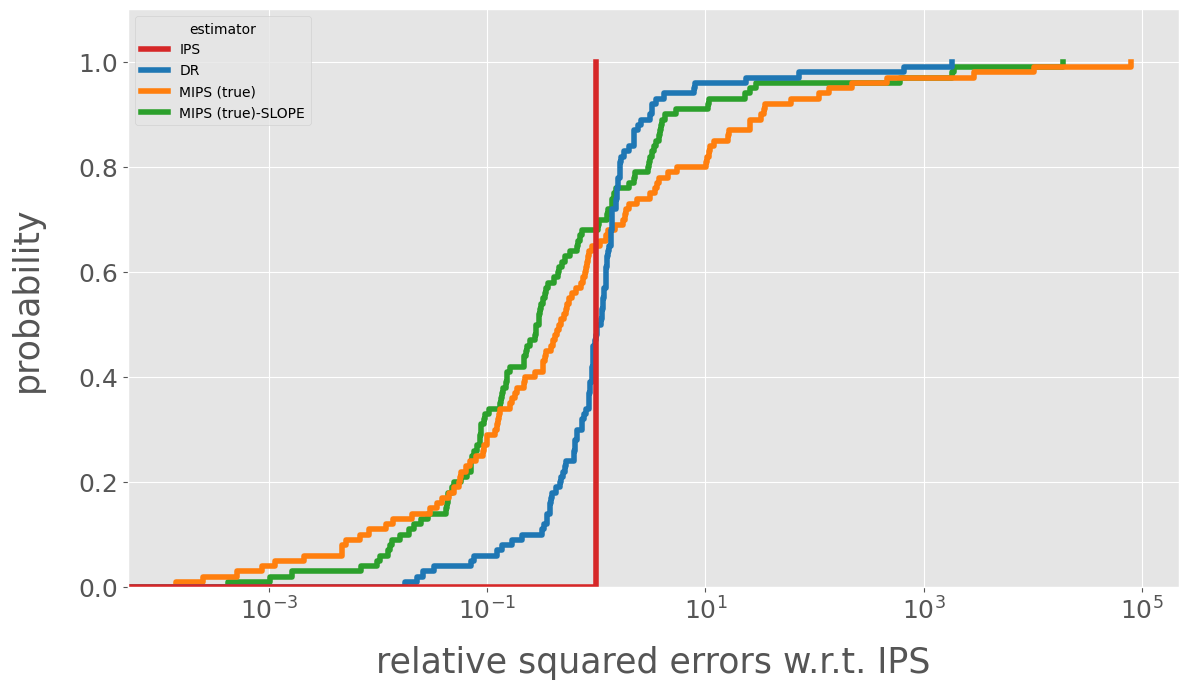

In [11]:
# CDF of Ralative Error
rel_result_df = result_df[result_df["x"] == 1000].copy()
visualize_cdf_of_ralative_error(rel_result_df=rel_result_df)